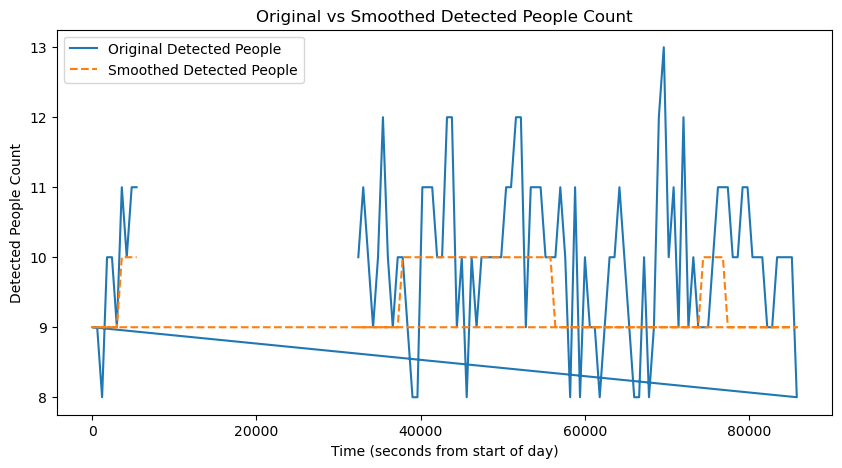

입력 데이터 크기: (2959, 6)
출력 데이터 크기: (2959,)


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# 1. 데이터 로드
file_path = '/Users/a0000/Desktop/cafe 1 data.csv'
df = pd.read_csv(file_path, encoding='utf-8-sig')
df.columns = ['date', 'time', 'detected_people']  # 컬럼명 지정

# 2. 시간 변환
df['date'] = pd.to_datetime(df['date'])  # 날짜를 datetime 형식으로 변환
df['time'] = pd.to_timedelta(df['time']).dt.total_seconds().astype(int)  # 시간 컬럼을 초 단위로 변환

# 3. Gaussian smoothing
sigma = 10  # 스무딩 강도
df['detected_people_smoothed'] = gaussian_filter1d(df['detected_people'], sigma)

# 4. Min-Max 스케일링
scaler = MinMaxScaler()  # 스케일러 생성
df['scaled_detected_people'] = scaler.fit_transform(df[['detected_people_smoothed']])  # fit_transform으로 스케일링 적용

# 5. 데이터 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['time'][:100], df['detected_people'][:100], label='Original Detected People')
plt.plot(df['time'][:100], df['detected_people_smoothed'][:100], label='Smoothed Detected People', linestyle='--')
plt.xlabel('Time (seconds from start of day)')
plt.ylabel('Detected People Count')
plt.legend()
plt.title('Original vs Smoothed Detected People Count')
plt.show()

# 학습 데이터 생성
time_window = 6  # 학습에 사용할 시간 창(단위: 10분 간격)
prediction_time = 6  # 예측할 시간 이후의 데이터

# 학습용 입력 데이터와 출력 데이터 생성
x_train, y_train = [], []
for i in range(len(df) - time_window - prediction_time):
    x_train.append(df['scaled_detected_people'].iloc[i:i + time_window].values)
    y_train.append(df['scaled_detected_people'].iloc[i + time_window + prediction_time])

x_train, y_train = np.array(x_train), np.array(y_train)

# 데이터 확인
print("입력 데이터 크기:", x_train.shape)
print("출력 데이터 크기:", y_train.shape)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# GRU 모델 구성
model = Sequential([
    GRU(100, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    GRU(50),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 출력
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 6, 100)         │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,751 (209.96 KB)

 Trainable params: 53,751 (209.96 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# 모델 학습
model.fit(x_train, y_train, epochs=3, batch_size=10, verbose=1)

# 학습 데이터로 예측 수행
predicted_values = model.predict(x_train)
predicted_values = scaler.inverse_transform(predicted_values)  # 스케일링 복원


Epoch 1/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0203
Epoch 2/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034
Epoch 3/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


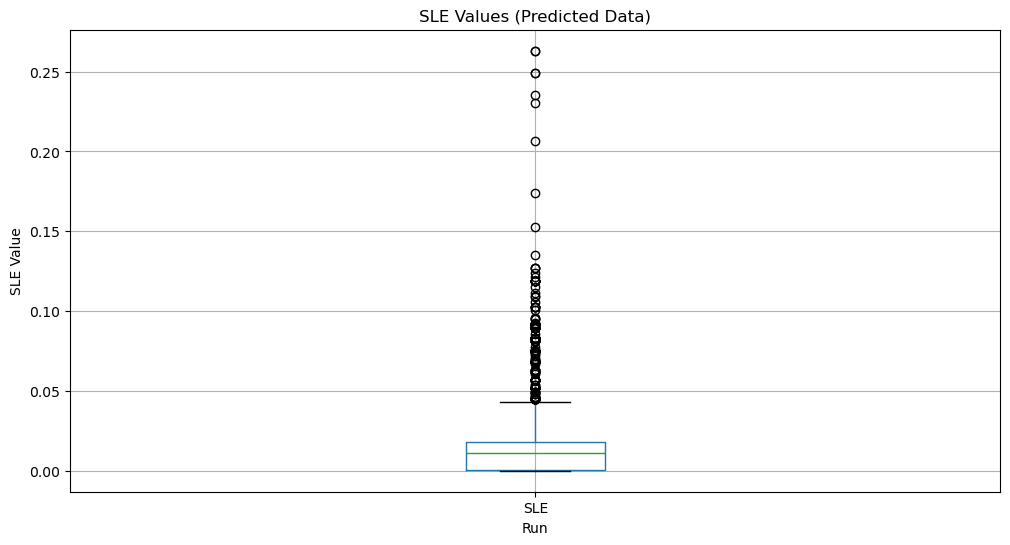

In [4]:
import matplotlib.pyplot as plt

# 실제값과 예측값의 SLE(Squared Log Error) 계산
# 'detected_people' 실제 값과 'predicted_values' 예측값을 비교하여 SLE 계산
SLE = np.square(np.log1p(df['detected_people'][-len(predicted_values):].values) - np.log1p(predicted_values.flatten()))

# SLE 결과를 DataFrame으로 변환하고 CSV 파일로 저장
SLE_df = pd.DataFrame({'SLE': SLE})
SLE_df.to_csv('/Users/a0000/Desktop/SLE_values.csv', index=False)

# SLE 시각화 (박스플롯)
plt.figure(figsize=(12, 6))
SLE_df.boxplot()
plt.title("SLE Values (Predicted Data)")
plt.xlabel("Run")
plt.ylabel("SLE Value")
plt.show()


In [5]:
# SLE 값의 통계 정보 계산
Q1 = SLE_df['SLE'].quantile(0.25)
Q3 = SLE_df['SLE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
num_outliers = ((SLE_df['SLE'] < lower_bound) | (SLE_df['SLE'] > upper_bound)).sum()

# 통계 정보를 DataFrame으로 변환하고 CSV 파일로 저장
statistics_df = pd.DataFrame({
    'Mean': [SLE_df['SLE'].mean()],
    'Median': [SLE_df['SLE'].median()],
    'Upper 25%': [Q3],
    'Lower 25%': [Q1],
    'Number of Outliers': [num_outliers]
})
statistics_df.to_csv('/Users/a0000/Desktop/SLE_statistics.csv', index=False)

# 통계 정보 출력
print(f"평균 SLE: {SLE.mean()}")
print(f"중앙값 SLE: {np.median(SLE)}")
print(f"상위 25% SLE: {Q3}")
print(f"하위 25% SLE: {Q1}")
print(f"이상치 개수: {num_outliers}")


평균 SLE: 0.01666817430851443
중앙값 SLE: 0.011159990506840358
상위 25% SLE: 0.017757657675486864
하위 25% SLE: 0.0006797865671427044
이상치 개수: 231
